In [1]:
def cell(T, pw, dt, p):
    """
    T = temperature, K
    pw = vector of initial wood concentration, kg/m^3
    dt = time step, s
    p = total number of time steps
    """

    # array to store species concentrations as a density, kg/m^3
    # row = chemical species
    # column = concentration at time step
    spec = np.zeros([16, p])

    # initial cellulose concentration in wood, kg/m^3
    spec[0] = pw*0.5

    R = 1.987   # universal gas constant, kcal/kmol*K

    # A = pre-factor (1/s) and E = activation energy (kcal/kmol)
    A1 = 4e13;  E1 = 45000  # CELL -> CELLA
    A2 = 0.5e9; E2 = 29000  # CELLA -> products
    A3 = 1.8;   E3 = 10000  # CELLA -> LVG
    A4 = 4e7;   E4 = 31000  # CELL -> 5*H2O + 6*Char

    # reaction rate constant for each reaction, 1/s
    K1 = A1 * np.exp(-E1 / (R * T))         # CELL -> CELLA
    K2 = A2 * np.exp(-E2 / (R * T))         # CELLA -> G2
    K3 = A3 * T * np.exp(-E3 / (R * T))     # CELLA -> LVG
    K4 = A4 * np.exp(-E4 / (R * T))         # CELL -> G1

    # concentrations for each chemical species, kg/m^3
    for i in range(1, p):
        r1 = K1 * spec[0, i-1]
        r2 = K2 * spec[1, i-1]
        r3 = K3 * spec[1, i-1]
        r4 = K4 * spec[0, i-1]
        spec[0, i] = spec[0, i-1] - (r1+r4)*dt          # CELL
        spec[1, i] = spec[1, i-1] + r1*dt - (r2+r3)*dt  # CELLA
        spec[2, i] = spec[2, i-1] + r4*dt               # G1
        spec[3, i] = spec[3, i-1] + r2*dt               # G2
        spec[4, i] = spec[4, i-1] + r3*dt               # LVG

    # return species array concentrations, kg/m^3
    return spec

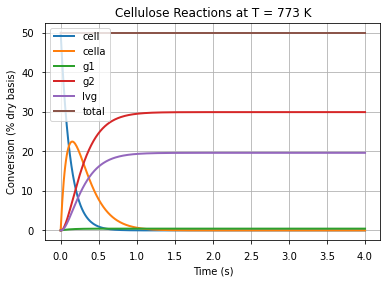

In [5]:
# Modules
#------------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as py
# import funcRanzi as kn

py.close('all')

# Parameters from Papadikis 2010a
#------------------------------------------------------------------------------

rhow = 700  # density of wood, kg/m^3
Tinf = 773  # ambient temp, K

# Initial Calculations
#------------------------------------------------------------------------------

dt = 0.01   # time step, delta t
tmax = 4   # max time, s
t = np.linspace(0, tmax, num=int(tmax/dt))   # time vector
p = len(t)  # total number of time steps

# Calculate Concentrations of Chemical Species
#------------------------------------------------------------------------------

# vectors for wood, gas, tar, char concentrations as a density, kg/m^3
pw = np.zeros(len(t))   # wood 
pg = np.zeros(len(t))   # gas
pt = np.zeros(len(t))   # tar
pc = np.zeros(len(t))   # char

pw[:] = rhow    # initial wood concentration as density

# array of chemical species concentrations as a density, kg/m^3
# spec = kn.cell(Tinf, pw, dt, p)
spec = cell(Tinf, pw, dt, p)

# concentration as percent relative to original wood, %
cell = spec[0]/rhow*100     # CELL
cella = spec[1]/rhow*100    # CELLA
g1 = spec[2]/rhow*100       # G1
g2 = spec[3]/rhow*100       # G2
lvg = spec[4]/rhow*100      # LVG

total = cell + cella + g1 + g2 + lvg

# Plot Results
#------------------------------------------------------------------------------

py.rcParams['xtick.major.pad'] = 8
py.rcParams['ytick.major.pad'] = 8
py.rcParams['lines.linewidth'] = 2
py.rcParams['axes.grid'] = True

py.figure(1)
py.plot(t, cell, label='cell')
py.plot(t, cella, label='cella')
py.plot(t, g1, label='g1')
py.plot(t, g2, label='g2')
py.plot(t, lvg, label='lvg')
py.plot(t, total, label='total')
py.title('Cellulose Reactions at T = {} K'.format(Tinf))
py.xlabel('Time (s)')
py.ylabel('Conversion (% dry basis)')
py.legend(loc='best', numpoints=1)
py.show()

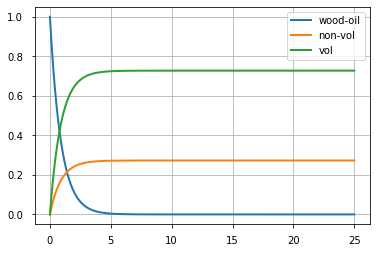

In [18]:
from scipy.integrate import odeint

dt = 0.0001                           # time step, delta t
tmax = 25                             # max time, s
t = np.linspace(0, tmax, num=int(tmax/dt)) # time vector
nt = len(t)                           # total number of time steps

def rates(c, t):
    """
    w = wood-oil as conc[0]
    nv = non-volatiles as conc[1]
    v = volatiles as conc[2]
    """
    Knv = 0.3
    Kv = 0.8
    rw = -(Knv + Kv) * c[0]
    rnv = Knv * c[0]
    rv = Kv * c[0]
    return [rw, rnv, rv]

cc = odeint(rates, [1, 0, 0], t)

py.figure(1)
py.plot(t, cc[:, 0], label='wood-oil')
py.plot(t, cc[:, 1], label='non-vol')
py.plot(t, cc[:, 2], label='vol')
# py.title('Cellulose Reactions at T = {} K'.format(Tinf))
# py.xlabel('Time (s)')
# py.ylabel('Conversion (% dry basis)')
py.legend(loc='best', numpoints=1)
py.show()

C:\Users\JYANG2\AppData\Local\Temp/ipykernel_22744/3841436870.py:18: RuntimeWarning: invalid value encountered in double_scalars
  rv = Kv*c[0] + Kcr*c[1]**cr - Kd*c[2]**d - Ka*c[2]**a - Kg*c[2]**g - Kr2*c[2]**r2


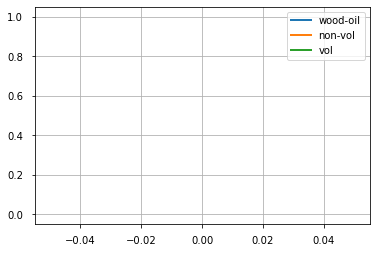

In [21]:
def dCdt(c, t):
    """
    w = wood-oil as conc[0]
    nv = non-volatiles as conc[1]
    v = volatiles as conc[2]
    """
    Knv = 0.3
    Kv = 0.8
    Kr1 = 9.2e7;    r1 = 2.5
    Kcr = 4.1e-5;   cr = 0.9
    Kc1 = 3.7e5;    c1 = 1.1
    Kd = 8.0e-4;    d = 0.9
    Ka = 6.1e-6;    a = 1.4
    Kg = 1.8e-4;    g = 0.8
    Kr2 = 37.0e5;   r2 = 0.7
    rw = -(Knv + Kv)*c[0]
    rnv = Knv*c[0] - Kr1*c[1]**r1 - Kcr*c[1]**cr - Kc1*c[1]**c1
    rv = Kv*c[0] + Kcr*c[1]**cr - Kd*c[2]**d - Ka*c[2]**a - Kg*c[2]**g - Kr2*c[2]**r2
    return [rw, rnv, rv]

cc2 = odeint(dCdt, [1, 0, 0], t)

py.figure(1)
py.plot(t, cc2[:, 0], label='wood-oil')
py.plot(t, cc2[:, 1], label='non-vol')
py.plot(t, cc2[:, 2], label='vol')
# py.title('Cellulose Reactions at T = {} K'.format(Tinf))
# py.xlabel('Time (s)')
# py.ylabel('Conversion (% dry basis)')
py.legend(loc='best', numpoints=1)
py.show()

In [22]:
from scipy.integrate import solve_ivp
from scipy.special import gamma, airy
y1_0 = +1 / 3**(2/3) / gamma(2/3)
y0_0 = -1 / 3**(1/3) / gamma(1/3)
y0 = [y0_0, y1_0]
def func(t, y):
    return [t*y[1],y[0]]

t_span = [0, 4]
sol1 = solve_ivp(func, t_span, y0)
print("sol1.t: {}".format(sol1.t))

sol1.t: [0.         0.10097672 1.04643602 1.91060117 2.49872472 3.08684827
 3.62692846 4.        ]


In [23]:
print("sol1.y[1]: {}".format(sol1.y[1]))
print("airy(sol.t)[0]:  {}".format(airy(sol1.t)[0]))

sol1.y[1]: [0.35502805 0.328952   0.12801343 0.04008508 0.01601291 0.00623879
 0.00356316 0.00405982]
airy(sol.t)[0]:  [0.35502805 0.328952   0.12804768 0.03995804 0.01575943 0.00562799
 0.00201689 0.00095156]


In [24]:
rtol, atol = (1e-8, 1e-8)
sol2 = solve_ivp(func, t_span, y0, rtol=rtol, atol=atol)
print("sol2.y[1][::6]: {}".format(sol2.y[1][0::6]))
print("airy(sol2.t)[0][::6]: {}".format(airy(sol2.t)[0][::6]))

sol2.y[1][::6]: [0.35502805 0.19145234 0.06368989 0.0205917  0.00554734 0.00106409]
airy(sol2.t)[0][::6]: [0.35502805 0.19145234 0.06368989 0.0205917  0.00554733 0.00106406]


In [28]:
import numpy as np
t = np.linspace(0, 4, 100)
sol3 = solve_ivp(func, t_span, y0, rtol=rtol, atol=atol, t_eval=t)

print("sol3.y[1][::6]: {}".format(sol3.y[1][0::6]))
print("airy(sol3.t)[0][::6]: {}".format(airy(sol3.t)[0][::6]))

sol3.y[1][::6]: [0.35502805 0.29305286 0.23511457 0.18376132 0.14017728 0.10452558
 0.07628829 0.05455969 0.03827267 0.0263561  0.01783113 0.01185978
 0.0077596  0.00499698 0.00316883 0.00197977 0.0012191 ]
airy(sol3.t)[0][::6]: [0.35502805 0.29305286 0.23511457 0.18376132 0.14017729 0.10452558
 0.07628829 0.05455969 0.03827267 0.02635609 0.01783112 0.01185977
 0.0077596  0.00499697 0.00316883 0.00197976 0.00121908]


In [30]:
def gradient(t, y):
    return [[0,t], [1,0]]
sol4 = solve_ivp(func, t_span, y0, rtol=rtol, atol=atol, method='Radau', jac=gradient)

print("sol4.y[1][::6]: {}".format(sol4.y[1][0::6]))
print("airy(sol4.t)[0][::6]: {}".format(airy(sol4.t)[0][::6]))

sol4.y[1][::6]: [0.35502805 0.29677781 0.23284808 0.17698664 0.13064747 0.09384843
 0.06571239 0.04143047 0.02436078 0.01277487 0.00641608 0.00299579
 0.00125323]
airy(sol4.t)[0][::6]: [0.35502805 0.29677781 0.23284808 0.17698664 0.13064747 0.09384843
 0.06571239 0.04143047 0.02436078 0.01277487 0.00641608 0.00299579
 0.00125323]


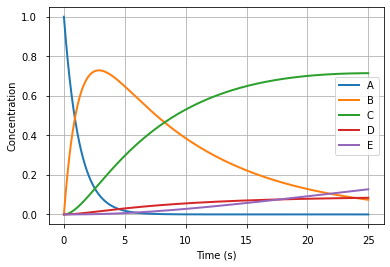

In [63]:
from scipy.integrate import odeint

dt = 0.0001                           # time step, delta t
tmax = 25                             # max time, s
t = np.linspace(0, tmax, num=int(tmax/dt)) # time vector
nt = len(t)                           # total number of time steps

def rates(c, t):
    """
    w = wood-oil as conc[0]
    nv = non-volatiles as conc[1]
    v = volatiles as conc[2]
    """
    K1 = 0.8
    K2 = 0.1
    K3 = 0.01
    K4 = 0.01
    r0 = -K1 * c[0]
    r1 = K1 * c[0] - K2 * c[1] - K3 * c[1]
    r2 = K2 * c[1] - K4 * c[2]
    r3 = K3 * c[1]
    r4 = K4 * c[2]
    return [r0, r1, r2, r3, r4]

cc = odeint(rates, [1, 0, 0, 0, 0], t)
cc_name = ['A', 'B', 'C', 'D', 'E']

py.figure(1)
for i in range(cc.shape[1]):
    py.plot(t, cc[:, i], label=cc_name[i])

# py.title('Cellulose Reactions at T = {} K'.format(Tinf))
py.xlabel('Time (s)')
py.ylabel('Concentration')
py.legend(loc='best', numpoints=1)
py.show()

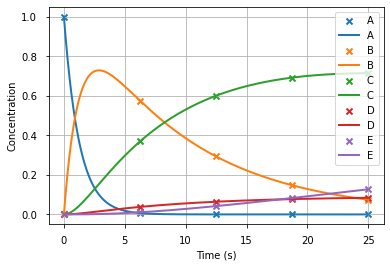

In [68]:
dt = 5                           # time step, delta t
tmax = 25                             # max time, s
t2 = np.linspace(0, tmax, num=int(tmax/dt)) # time vector
nt = len(t2)                           # total number of time steps

def rates(c, t2):
    """
    w = wood-oil as conc[0]
    nv = non-volatiles as conc[1]
    v = volatiles as conc[2]
    """
    K1 = 0.8
    K2 = 0.1
    K3 = 0.01
    K4 = 0.01
    r0 = -K1 * c[0]
    r1 = K1 * c[0] - K2 * c[1] - K3 * c[1]
    r2 = K2 * c[1] - K4 * c[2]
    r3 = K3 * c[1]
    r4 = K4 * c[2]
    return [r0, r1, r2, r3, r4]

cc2 = odeint(rates, [1, 0, 0, 0, 0], t2)
cc_name = ['A', 'B', 'C', 'D', 'E']

py.figure(1)
for i in range(cc.shape[1]):
    py.scatter(t2, cc2[:, i], label=cc_name[i], marker='x')
    py.plot(t, cc[:, i], label=cc_name[i])

# py.title('Cellulose Reactions at T = {} K'.format(Tinf))
py.xlabel('Time (s)')
py.ylabel('Concentration')
py.legend(loc='best', numpoints=1)
py.show()